## k-Nearest Neighbors
In pattern recognition, the k-nearest neighbors algorithm (k-NN) is a non-parametric method used for classification and regression.In both cases, the input consists of the k closest training examples in the feature space.

In [1]:
# Import all necessary modules

import pandas as pd
from scipy.io import arff
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import operator
import math
from sklearn import preprocessing

In [2]:
# Loading the data

datatrain = arff.loadarff('trainProdSelection.arff')
dtrain = pd.DataFrame(datatrain[0])
str_df = dtrain.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for i in str_df:
    dtrain[i] = str_df[i]
dtrain.head()

,Type,LifeStyle,Vacation,eCredit,salary,property,label
0,student,spend>saving,6.0,40.0,13.62,3.2804,C1
1,student,spend>saving,11.0,21.0,15.32,2.0232,C1
2,student,spend>saving,7.0,64.0,16.55,3.1202,C1
3,student,spend>saving,3.0,47.0,15.71,3.4022,C1
4,student,spend>saving,15.0,10.0,16.96,2.2825,C1


In [3]:
# Train dataset size
dtrain.shape

(186, 7)

In [4]:
# Finding unique lables from train dataset
dtrain.label.unique()

array(['C1', 'C2', 'C3', 'C4', 'C5'], dtype=object)

In [5]:
# Count of each attribute
dtrain.Type.value_counts()

engineer     49
professor    39
student      38
doctor       37
librarian    23
Name: Type, dtype: int64

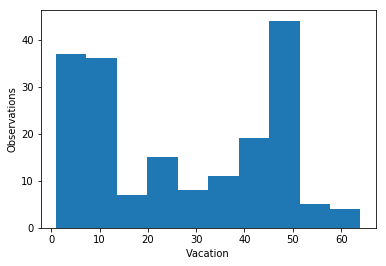

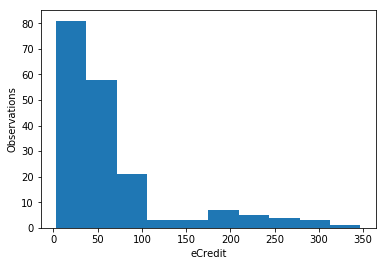

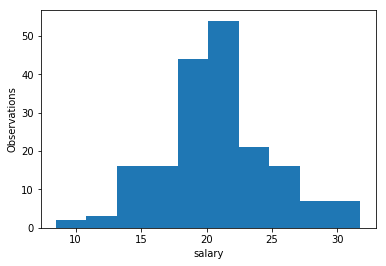

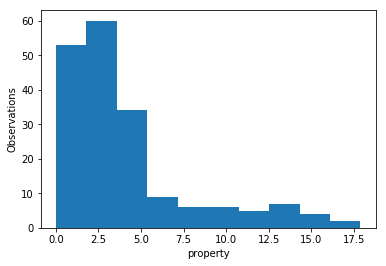

In [6]:
# Plotted graph for Vacation-Observations,eCredit-Observations,salary-Observations,property-Observations

%matplotlib inline
from matplotlib import pyplot as plt
for i in ["Vacation","eCredit","salary","property"]:
    plt.hist(dtrain[i])
    plt.xlabel(i)
    plt.ylabel("Observations")
    plt.show()

In [7]:
# Finding the min and max values of Vacation, eCredit, Salary and Property

minV = dtrain.Vacation.min()
maxV = dtrain.Vacation.max()
dtrain.Vacation = dtrain.Vacation.apply(lambda x:(x-minV)/(maxV-minV))
mineC = dtrain.eCredit.min()
maxeC = dtrain.eCredit.max()
dtrain.eCredit = dtrain.eCredit.apply(lambda x:(x-mineC)/(maxeC-mineC))
minsalary = dtrain.salary.min()
maxsalary = dtrain.salary.max()
dtrain.salary = dtrain.salary.apply(lambda x:(x-minsalary)/(maxsalary-minsalary))
minp = dtrain.property.min()
maxp = dtrain.property.max()
dtrain.property = dtrain.property.apply(lambda x:(x-minp)/(maxp-minp))
dtrain.head() 

,Type,LifeStyle,Vacation,eCredit,salary,property,label
0,student,spend>saving,0.079365,0.107558,0.219960,0.183167,C1
1,student,spend>saving,0.158730,0.052326,0.293102,0.112797,C1
2,student,spend>saving,0.095238,0.177326,0.346023,0.174200,C1
3,student,spend>saving,0.031746,0.127907,0.309882,0.189984,C1
4,student,spend>saving,0.222222,0.020349,0.363663,0.127311,C1


/usr/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

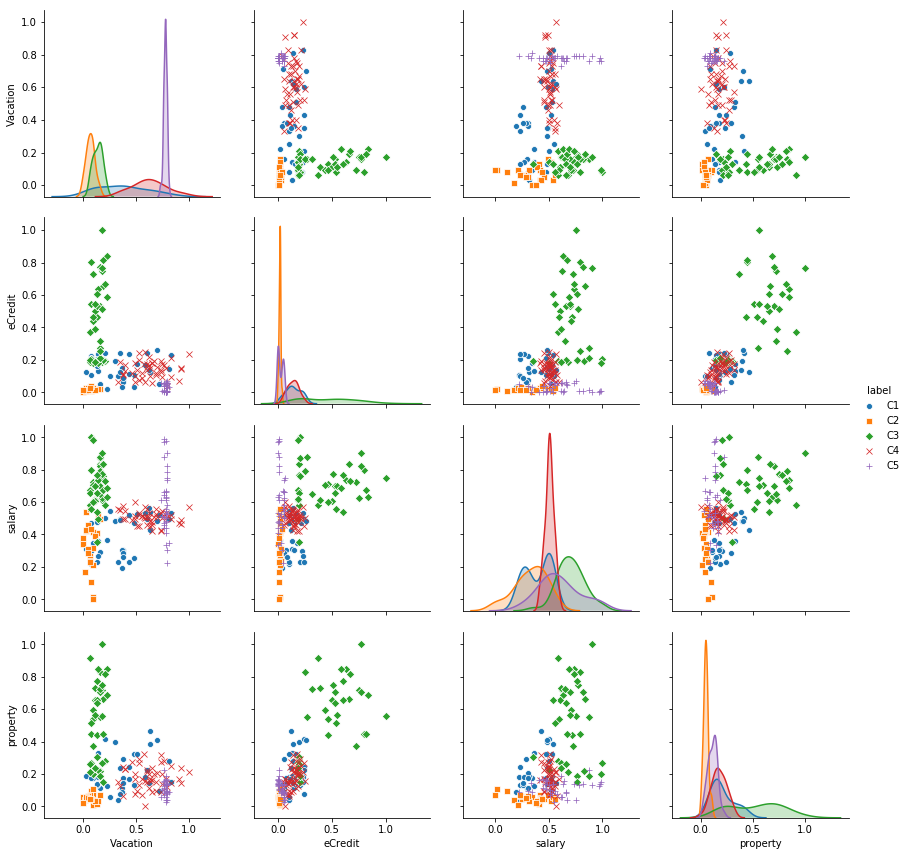

In [8]:
# Pairplots for Vacation, eCredit, Salary and Property

import seaborn as sns
train_df = dtrain.copy()
plt.figure()
sns.pairplot(train_df, hue = 'label', size=3, markers=["o", "s", "D","x","+"])
plt.show()

In [9]:
# Reading the similarity matrix

similarityMatrix = pd.read_excel("similaritymatrix.xls")

In [10]:
# View content in similarity matrix

similarityMatrix

,student,engineer,librarian,professor,doctor
student,1,0,0,0,0.0
engineer,0,1,0,0,0.0
librarian,0,0,1,0,0.0
professor,0,0,0,1,0.0
doctor,0,0,0,0,1.0
NaN,NaN,NaN,NaN,NaN,NaN
NaN,spend<<saving,spend<saving,spend>saving,spend>>saving,NaN
spend<<saving,1,0,0,0,NaN
spend<saving,0,1,0,0,NaN
spend>saving,0,0,1,0,NaN


In [11]:
# Splitting the dataset in train and valid

df_train = dtrain[:162]
df_valid = dtrain[162:]
df_train.tail()

,Type,LifeStyle,Vacation,eCredit,salary,property,label
157,professor,spend>saving,0.761905,0.005814,0.469504,0.104541,C5
158,professor,spend>saving,0.777778,0.000000,0.335697,0.143885,C5
159,professor,spend>>saving,0.761905,0.005814,0.645476,0.154251,C5
160,professor,spend>>saving,0.777778,0.005814,0.611056,0.186268,C5
161,professor,spend>>saving,0.777778,0.000000,0.476818,0.161874,C5


In [12]:
# Reset the index column

df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train.tail()

,Type,LifeStyle,Vacation,eCredit,salary,property,label
157,librarian,spend>saving,0.095238,0.020349,0.415942,0.067979,C2
158,doctor,spend>saving,0.095238,0.441860,0.705710,0.596881,C3
159,doctor,spend>saving,0.158730,0.270349,0.876519,0.549662,C3
160,doctor,spend>saving,0.111111,0.389535,0.613207,0.732773,C3
161,student,spend<saving,0.206349,0.194767,0.581799,0.282693,C3


In [13]:
# Building code for k-Nearest Neighbors

import operator
class knn(object):
    
    def __init__(self,neighbors=None,matrix1=None,matrix2=None,minV=None,maxV=None):
        self.trainData_X = None
        self.trainData_Y = None
        self.neighbors = neighbors
        self.similaritiesMatrix1 = matrix1
        self.similaritiesMatrix2 = matrix2
        self.maxValues = maxV
        self.minValues = minV
        
    def fit(self,X,Y):
        self.trainData_X = X
        self.trainData_Y = Y
    
    def similarities(self,x1,x2):     
        d= np.square(self.similaritiesMatrix1[x1[0]][x2[0]])
        d+= np.square(self.similaritiesMatrix2[x1[1]][x2[1]])
        for i in range(2,len(x1)):
            mn,mx = self.minValues[str(i)],self.maxValues[str(i)]
            if mx !=None or mn!=None:
                d+= np.square((x1[i]-x2[i])/(mx-mn))
        return np.sqrt(d)   
    
    def Votes(self,lst):
        mode = [None]
        mx=0
        for i in range(len(lst)):
            c=0
            for j in range(len(lst)):
                if lst[i]==lst[j]:
                    c+=1
            if mx<c:
                if lst[i] not in mode:
                    mode[0] = lst[i]
                mx = c
            elif mx==c:
                if lst[i] not in mode:
                    mode.append(lst[i])
        if not mode[0]:
            return lst
        return mode[0]
     
    def predict(self,X_test,Y_test):
        if not self.neighbors:
            self.neighbors = 3
        predictClass = []
        for e in range(len(X_test)):
            distances={}
            for x_i in range(len(self.trainData_X)):
                dist = self.similarities(X_test[e],self.trainData_X[x_i])
                distances[x_i] = dist
            sorted_d = sorted(distances.items(),key=operator.itemgetter(1))
            kneighbors = [self.trainData_Y[x[0]] for x in sorted_d[:self.neighbors]]
            kVotes = self.Votes(kneighbors)
            predictClass.append(kVotes)            
        return predictClass

In [14]:
# Adding the min and max values of attributes to a dictionary

minValues = {"1":None,"2":None,"3":dtrain['Vacation'].min(),"4":dtrain.eCredit.min(),"5":dtrain.salary.min(),"6":dtrain.property.min()}
maxValues = {"1":None,"2":None,"3":dtrain.Vacation.max(),"4":dtrain.eCredit.max(),"5":dtrain.salary.max(),"6":dtrain.property.max()}

In [15]:
# Calling the kNN with k=3

model_valid = knn(neighbors=3,matrix1='customer_type',matrix2='lifeStyle',minV=minValues,maxV=maxValues)
model_valid.fit(df_train.values[:,[0,1,2,3,4,5]],df_train.values[:,[6]])

In [16]:
# Reading the testProdSelection.arff dataset

datatest = arff.loadarff("testProdSelection.arff")
dtest = pd.DataFrame(datatest[0])
str_df = dtest.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for i in str_df:
    dtest[i] = str_df[i]
dtest.head()

,Type,LifeStyle,Vacation,eCredit,salary,property,label
0,student,spend<saving,12.0,19.0,14.7900,3.7697,C1
1,student,spend>>saving,29.0,10.0,16.1900,2.4839,C1
2,student,spend<<saving,28.0,60.0,15.4600,1.1885,C1
3,engineer,spend>saving,15.0,41.0,21.2600,1.4379,C1
4,librarian,spend<saving,2.0,9.0,19.7207,0.6913,C1


In [17]:
df_test = dtest

In [18]:
# Finding the max values of attributes in new dataset


minValues2 = [df_test['Vacation'].min(),df_test.eCredit.min(),df_test.salary.min(),df_test.property.min()]
maxValues2 = [df_test.Vacation.max(),df_test.eCredit.max(),df_test.salary.max(),df_test.property.max()]

In [19]:
# Normalizing the new dataset

df_test.eCredit=dtest['eCredit'].apply(lambda x : (x-minValues2[1])/(maxValues2[1]-minValues2[1]))

df_test.salary=dtest['salary'].apply(lambda x : (x-minValues2[2])/(maxValues2[2]-minValues2[2]))

df_test.Vacation=dtest['Vacation'].apply(lambda x : (x-minValues2[0])/(maxValues2[0]-minValues2[0]))

df_test.property=dtest['property'].apply(lambda x : (x-minValues2[3])/(maxValues2[3]-minValues2[3]))

In [20]:
# Finding the size of new test dataset

x_test = df_test.values
x_test.shape

(21, 7)

In [21]:
# Splitting the new dataset into x_test and y_test

x = dtrain.values
X = x[:,[0,1,2,3,4]]
Y=x[:,6]
y_test = x_test[:,6]
x_test = x_test[:,[0,1,2,3,4]]

In [22]:
# Creating the dummy variables and making the 'lifestyle' into categorical value

customer_type=similarityMatrix[:5]
lifeStyle = similarityMatrix[7:]
lifeStyle

,student,engineer,librarian,professor,doctor
spend<<saving,1,0,0,0,NaN
spend<saving,0,1,0,0,NaN
spend>saving,0,0,1,0,NaN
spend>>saving,0,0,0,1,NaN


In [23]:
# Renaming columsn and dropping the ones with None 

lifeStyle.columns = ["spend<<saving","spend<saving","spend>saving","spend>>saving","None"]
lifeStyle.drop(['None'],axis=1)
customer_type

,student,engineer,librarian,professor,doctor
student,1,0,0,0,0.0
engineer,0,1,0,0,0.0
librarian,0,0,1,0,0.0
professor,0,0,0,1,0.0
doctor,0,0,0,0,1.0


In [24]:
# Fitting the model with k=5

model = knn(neighbors=5,matrix1=customer_type,matrix2=lifeStyle,minV = minValues,maxV = maxValues)

model.fit(X,Y)

predTest = model.predict(x_test,y_test)

In [25]:
# Finding the Correlation

dtrain.corr(method="pearson")

,Vacation,eCredit,salary,property
Vacation,1.000000,-0.355139,0.110022,-0.296422
eCredit,-0.355139,1.000000,0.408194,0.830698
salary,0.110022,0.408194,1.000000,0.427750
property,-0.296422,0.830698,0.427750,1.000000


In [26]:
# Listing the predicted column

pd.Series(predTest).tolist()

['C2',
 'C2',
 'C2',
 'C4',
 'C5',
 'C1',
 'C2',
 'C1',
 'C3',
 'C1',
 'C3',
 'C1',
 'C1',
 'C1',
 'C4',
 'C4',
 'C4',
 'C1',
 'C2',
 'C5',
 'C2']

In [27]:
# Finding the average of each attribute

r=pd.Series(predTest).value_counts()
round((r/len(predTest))*100,2)

C1    33.33
C2    28.57
C4    19.05
C3     9.52
C5     9.52
dtype: float64

In [28]:
# Finding the accuracy for y_test, predTest

from sklearn.metrics import accuracy_score
accuracy_score(y_test,predTest)

0.3333333333333333

In [29]:
# Converting the 'Type', 'LifeStyle', 'label' columns into catergorical using one-hot encoding

dtest['Type'] = dtest.Type.map({'student':2,'engineer':3,'librarian':1,'professor':4,'doctor':5})
dtest['LifeStyle'] = dtest.LifeStyle.map({'spend<<saving':1, 'spend<saving':2,'spend>saving':3, 'spend>>saving':4})
dtest['label'] = dtest.label.map({'C1':1,'C2':2,'C3':3,'C4':4,'C5':5})
dtest.head()

,Type,LifeStyle,Vacation,eCredit,salary,property,label
0,2,2,0.20,0.058824,0.104637,0.398926,1
1,2,4,0.54,0.021008,0.175059,0.243041,1
2,2,1,0.52,0.231092,0.138339,0.085992,1
3,3,3,0.26,0.151261,0.430086,0.116229,1
4,1,2,0.00,0.016807,0.352657,0.025714,1


In [30]:
# Normalizing the new table

minV = dtest.Vacation.min()
maxV = dtest.Vacation.max()
dtest.Vacation = dtest.Vacation.apply(lambda x:(x-minV)/(maxV-minV))
mineC = dtest.eCredit.min()
maxeC = dtest.eCredit.max()
dtest.eCredit = dtest.eCredit.apply(lambda x:(x-mineC)/(maxeC-mineC))
minsalary = dtest.salary.min()
maxsalary = dtest.salary.max()
dtest.salary = dtest.salary.apply(lambda x:(x-minsalary)/(maxsalary-minsalary))
minp = dtest.property.min()
maxp = dtest.property.max()
dtest.property = dtest.property.apply(lambda x:(x-minp)/(maxp-minp))
dtest.shape

(21, 7)

In [34]:
# Applying k-Nearest Neighbors code again

def euclideanDistance(data1,data2,length):
    distance = 0
    for i in range(length):
        distance += np.square(data1[i]-data2[i])
    return np.sqrt(distance)
def KNN(trainset,testset,k):
    distances = {}
    length = len(testset)-1
    for i in range(len(trainset)):
        dist = euclideanDistance(testset,trainset[i],length)
        dist=math.floor(dist)
        distances[i]=dist
    sortedd = sorted(distances.items(),key=operator.itemgetter(1))
    print(sortedd)
    neighbors = []
    for i in range(k):
        neighbors.append(sortedd[i])
    return(neighbors)
def getresponse(neis):
    classvotes = {}
    for i in range(len(neis)):
        response = neis[i][-1]
        if response in classvotes:
            classvotes[response]+=1
        else:
            classvotes[response] = 1
    sortedvotes = sorted(classvotes.items(),key = operator.itemgetter(1),reverse = True)
    print(sortedvotes)
    print("**********************")
    return sortedvotes[0][0]
def getaccuracy(testset,predict):
    correct = 0
    for x in range(len(testset)):
        if testset[x][-1] == predict[x]:
            correct += 1
    return (correct/float(len(testset))) * 100.0
        
k=7
predict = []
for i in range(len(dtest)):
    nei=KNN(dtrain.values,dtest.values[i],k)
    result = getresponse(nei)
    predict.append(result)
print(predict)
accuracy = getaccuracy(dtest.values,predict)
print(accuracy)

[(145, 0), (147, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (113, 1), (114, 1), (115, 1), (116, 1), (117, 1), (119, 1), (129, 1), (131, 1), (133, 1), (134, 1), (135, 1), (136, 1), (137, 1), (139, 1), (141, 1), (143, 1), (144, 1), (146, 1), (149, 1), (168, 1), (169, 1), (170, 1), (171, 1), (172, 1), (173, 1), (174, 1), (175, 1), (176, 1), (9, 2), (10, 2), (11, 2), (12, 2), (13, 2), (26, 2), (27, 2), (28, 2), (29, 2), (50, 2), (51, 2), (52, 2), (53, 2), (54, 2), (55, 2), (56, 2), (57, 2), (58, 2), (59, 2), (60, 2), (61, 2), (112, 2), (118, 2), (120, 2), (121